<a href="https://colab.research.google.com/github/wimming0703/-/blob/main/assignment_2(%EC%88%98%EC%A0%95).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Image Classification

In this assignment, you will train an image classification model using **your own dataset**.

You must submit:
1. Report (PDF)
2. Code (.ipynb)
3. Dataset (.zip)
   - You may submit a downloadable link if the dataset size is too large

---

## Report (PDF)

Your report should include the following:

### 1. Dataset & Category Selection
- Why did you choose these four categories?
- Why is this topic interesting to you?
- What visual characteristics do you expect the model to use for classification?

### 2. Initial Training Results & Analysis
- Show the first experiment without data cleaning
- Analyze training/validation curves
  - Any signs of overfitting or underfitting?
- Analyze error cases: Why did the model misclassify?
- Explain why we use **pre-trained models** instead of random initialization

### 3. Data Cleaning Strategy
- Describe your data filtering or augmentation criteria
- Provide examples of removed or corrected data if applicable

### 4. Improved Model Results After Data Cleaning
- Compare with the initial results
- Include training curves and relevant performance metrics

### 5. Custom Test Image Experiments
- Evaluate the model using external images not in the dataset
- Analyze both successful and failed predictions
- Hypothesize what visual patterns the model is relying on for classification
- Choose test samples that provide evidence supporting your hypothesis

---

## Evaluation Criteria

1. How interesting and meaningful the selected topic is
2. Quality and depth of analysis in the report
3. How well error cases and model limitations are interpreted
4. **How appropriately test images are selected/modified to reveal the model’s decision patterns**, and how well the reasoning is supported by experiments
5. Completeness of submission (code, data, plots, explanations, etc.)

---


## 0. Install Library and Import

In [2]:
!git clone https://github.com/jdasam/jmd_imagescraper.git
%cd jmd_imagescraper
!pip install -q .
%cd ..
!pip install -q koreanize-matplotlib

import random
import shutil
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import time
import koreanize_matplotlib


from pathlib import Path
from jmd_imagescraper.core import duckduckgo_search
from PIL import Image



Cloning into 'jmd_imagescraper'...
remote: Enumerating objects: 303, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 303 (delta 0), reused 0 (delta 0), pack-reused 297 (from 1)
Receiving objects: 100% (303/303), 1.17 MiB | 15.18 MiB/s, done.
Resolving deltas: 100% (140/140), done.
/content/jmd_imagescraper
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.3 MB/s eta 0:00:00
/content
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 50.7 MB/s eta 0:00:00


## 1. Configure Settings
- 1) Select the storage type
  - Since Colab storage is volatile, your image dataset or model would disappear after the session ends.
  - There are two options to save the data permanently:
    1. Save your data in your local computer by downloading it from Colab. select `SAVE_TYP='local'`
    2. Save your data in your Google Drive storage. select `SAVE_TYP='google_drive'`
  - If you are running on your local computer, use `SAVE_TYP='local'`
- 2) Select Number of images you want to collect
  - `NUM_IMG` will define the number of image per category for crawling
  - `100<=NUM_IMG<=500` of your choice

In [3]:
SAVE_TYP = 'local'
# SAVE_TYP = 'google_drive'
NUM_IMG = 100 # This will define how many images you will download

try: # check whether you are running the notebook on colab
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  if SAVE_TYP == 'local': # if you selected to save it in local
    from google.colab import files
  else:
    from google.colab import drive # if you selected to save it in your Google Drive
    drive.mount('/content/drive')
    GGL_DIR = Path('/content/drive/MyDrive/Data_AI_Assignment2/')
    GGL_DIR.mkdir(exist_ok=True)

IMG_DIR = Path('images')
if IN_COLAB and SAVE_TYP=="google_drive":
  PLOT_DIR = GGL_DIR / "plots/"
else:
  PLOT_DIR = Path('plots')
PLOT_DIR.mkdir(exist_ok=True)
DEL_DIR = IMG_DIR / 'deleted'

## Problem 1: Collect Data
- You have to select 4 image categories of your own choice
- The selected categories will be used as an image class for the classification model
- TODO:
  - Explain why did you choose these categories for image classification
    - Why is it interesting topic to you?
    - What kind of visual characteristics would the model use for the classification?

In [4]:
def configure_image_categories():
  '''
  input: None
  output: List of strings that contains 4 classes

  example: image_keywords = ['football', 'basketball', 'baseball', 'volleyball']
  '''
  # TODO: Complete the function
  image_keywords = ['violin', 'flute', 'piano', 'timpani']
  return image_keywords

## Image Crawling
- Following code will automatically crawl the images with the keyword you have choosen
- After running it, it will automatically split train and valid to ratio of 8:2
  - Training data will be located `images/train`
  - Validation data will be locatd `images/valid`


#### Pre-defined Functions (run it without opening it)

In [5]:
'''
You don't have to change this cell
'''

def get_image_using_duckduckgo(img_dir:Path, image_types: list, num_img:int):
  for typ in image_types:
    duckduckgo_search(img_dir, typ, typ, max_results=NUM_IMG)
    typ_dir = img_dir / typ

def split_train_and_valid(img_dir, image_types, random_seed=0):
  random.seed(0)
  valid_indices = random.sample(range(NUM_IMG), NUM_IMG//5)
  image_keywords = [child.name for child in img_dir.iterdir() if child.is_dir()]
  for typ in image_keywords:
    typ_dir = img_dir / typ
    train_dir = img_dir / 'train' / typ
    test_dir = img_dir / 'test' / typ
    train_dir.mkdir(parents=True, exist_ok=True)
    test_dir.mkdir(parents=True, exist_ok=True)
    img_files = list(typ_dir.rglob('*.jpg'))
    valid_imgs = [img_files[i] for i in valid_indices]
    for fn in valid_imgs:
      shutil.move(fn, test_dir/fn.name)
    img_files = list(typ_dir.rglob('*.jpg'))
    for fn in img_files:
      shutil.move(fn, train_dir/fn.name)
    os.rmdir(typ_dir)

def save_fig_with_date(figname):
  plt.savefig(PLOT_DIR/f"{figname}_{time.ctime().split(' ')[-2].replace(':', '')}.png")

def file_name_with_date(filename):
  filename = Path(filename)
  return f"{filename.stem}_{'_'.join(time.ctime().split(' ')[1:4])}{filename.suffix}"

def save_file(fn):
  if IN_COLAB: # If you are running this notebook on Colab
    if SAVE_TYP == 'local': # if you selected to save it in local
      files.download(fn)   # download the file to your local computer
    else:
      shutil.copy(fn, GGL_DIR)  # copy the file to your google drive

def plot_random_sampled_images(img_dir, ncols=4, nrows=5,random_seed=0):
  # first, list all jpg files in the img_dir
  list_of_image_files = list(img_dir.rglob("*.jpg"))
  # randomly shuffle the order of image files
  # so that we can sample different images every time
  # but controlled by random seed
  # computer's random algorithm is pseudo random
  random.seed(random_seed)
  random.shuffle(list_of_image_files)

  # prepare empty canvas
  plt.figure(figsize=(ncols*5,nrows*4))

  # for each coloumn and row, load image and plot image on the canvas
  for i in range(ncols*nrows):
    fname = list_of_image_files[i]
    image = Image.open(fname)
    plt.subplot(nrows,ncols, i+1)
    plt.imshow(image)
    plt.title('/'.join(str(fname.parent).split('/')[-2:]))
    plt.axis('off')
  save_fig_with_date("dataset_check") # save figure as png in PLOT_DIR

In [6]:
# How to control random results
random.seed(0)
random.random(), random.random(), random.random() # return random float between 0 and 1

(0.8444218515250481, 0.7579544029403025, 0.420571580830845)

### Download or Unzip
- If this is your first time to download the dataset, it will automatically download the images fro duckduckgo search
- If you already ran the crawling code and have `image_data.zip` file in your local or google drive, you can upload it to the current Colab storage and unzip it

In [7]:
image_types = configure_image_categories()
print(image_types)
assert len(image_types)==4, "The length of image types has to be 4"
assert all( isinstance(typ, str) for typ in image_types), "Every element of image_types has to be string"


['violin', 'flute', 'piano', 'timpani']


- If you want to delete every file in the `images/`, you can run following code
  - `!rm -rf images/`
  - It will forcely remove every file and directory in images. So please be careful when using it
  

In [8]:
# delete the images/ folder if you want to re-compose your dataset
# !rm -rf images/

In [9]:
get_image_using_duckduckgo(IMG_DIR, image_types, NUM_IMG) # Download image files
split_train_and_valid(IMG_DIR, image_types) # Split train and valid into different directories
os.system(f"zip -rq image_data.zip {IMG_DIR}") # Make zip file that contains images directory
save_file("image_data.zip")


Duckduckgo search: violin


Duckduckgo search: flute


Duckduckgo search: piano


Duckduckgo search: timpani


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- Following code will download the dataset or unzip the pre-saved zip files

In [10]:
if not IMG_DIR.exists(): # If there is no image directory
  if Path("image_data_cleaned.zip").exists(): # if there is already cleaned dataset
    print("Extracting image_data_cleaned.zip")
    os.system("unzip -q image_data_cleaned.zip") # unzip image_data_cleaned.zip
  elif IN_COLAB and SAVE_TYP == "google_drive" and (GGL_DIR/"image_data_cleaned.zip").exists(): # if there is already cleaned dataset on GD
    print("Extracting image_data_cleaned.zip from Google Drive")
    shutil.copy(str(GGL_DIR/"image_data_cleaned.zip"), "/content/") # copy it to colab storage
    os.system("unzip -q image_data_cleaned.zip") # and unzip it
  elif Path("image_data.zip").exists(): # If image_data.zip file exists
    print("Extracting image_data.zip")
    os.system("unzip -q image_data.zip") # Unzip the zip file
  elif IN_COLAB and SAVE_TYP == "google_drive" and (GGL_DIR/"image_data.zip").exists():
    print("Extracting image_data.zip from Google Drive")
    shutil.copy(str(GGL_DIR/"image_data.zip"), "/content/")
    os.system("unzip -q image_data.zip")
  else: # If there is no image directory and also no image_data.zip
    print("Downloading images from DuckDuckGo")
    get_image_using_duckduckgo(IMG_DIR, image_types, NUM_IMG) # Download image files
    split_train_and_valid(IMG_DIR, image_types) # Split train and valid into different directories
    os.system(f"zip -rq image_data.zip {IMG_DIR}") # Make zip file that contains images directory
    save_file("image_data.zip")
else:
  print(f"IMG_DIR ({IMG_DIR}) already exists")

IMG_DIR (images) already exists


### Plot your Dataset
- It is always important to check your dataset in detail
- Run the script below and see the result
  - The figure will automatically saved as png with current time to `PLOT_DIR`

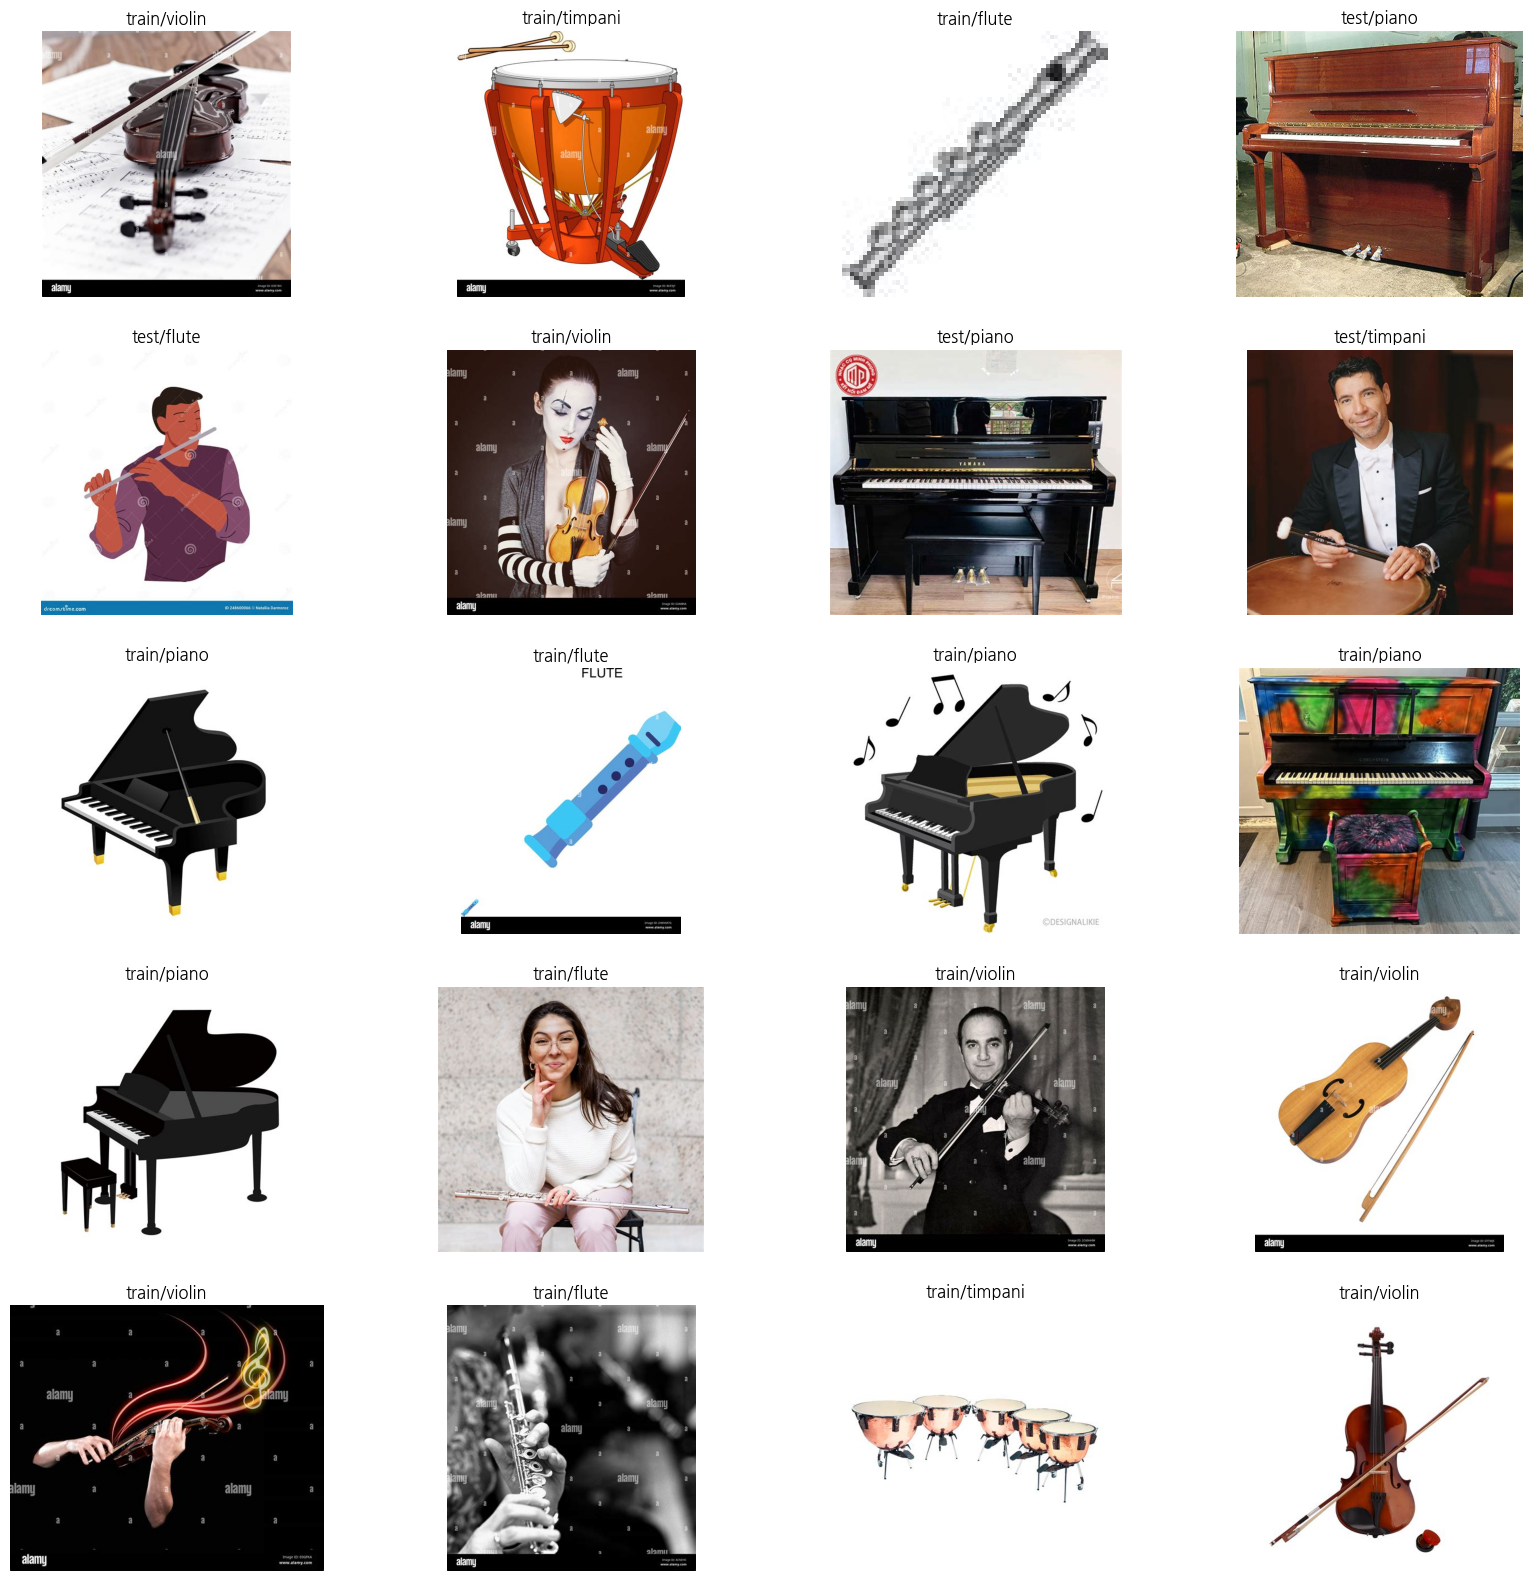

In [11]:
plot_random_sampled_images(IMG_DIR, ncols=4, nrows=5, random_seed=1)

## Problem 2: Report the first training result
- You don't have to change the code for Problem 2 if you have made the correct dataset on Problem 1
- TODO:
  - Explain how the training procedure looks like. Is there overfitting? Do you need more epochs to train the model?
  - Based on the error cases of the model, explain why the model makes such mistakes in your opinion
  - Explain why you need to use pre-trained weights, instead of random initialization

### Dataset Class


In [12]:
class ImageSet:
  def __init__(self, path_dir, file_types=['jpg', 'png'], transform=None):
    self.path = Path(path_dir)
    self.image_fns = sorted(item for y in [list(self.path.rglob(f'*.{x}')) for x in file_types] for item in y)
    self.classes = sorted(list(set([x.parent.name for x in self.image_fns])))
    self.cls2idx = {k: i for i, k in enumerate(self.classes)}
    self.transform = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

  def __len__(self):
    return len(self.image_fns)

  def __getitem__(self, idx):
    img_path = self.image_fns[idx]
    img = self.transform(Image.open(img_path).convert('RGB'))
    cls = img_path.parent.name
    return img, self.cls2idx[cls]

trainset = ImageSet(IMG_DIR/'train')
testset = ImageSet(IMG_DIR/'test')

Check the Batch result

In [13]:
tensor2pil = transforms.Compose([
    transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
    transforms.ToPILImage()
])


def show_batch(dataloader, ncols=4, nrows=5, random_seed=0):
  torch.manual_seed(random_seed)
  images, labels = next(iter(dataloader))
  plt.figure(figsize=(ncols*5,nrows*4))
  for i in range(ncols*nrows):
    plt.subplot(nrows, ncols, i+1)
    pil_img = tensor2pil(images[i])
    plt.imshow(pil_img)
    plt.title(trainset.classes[labels[i]])
    plt.axis('off')

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

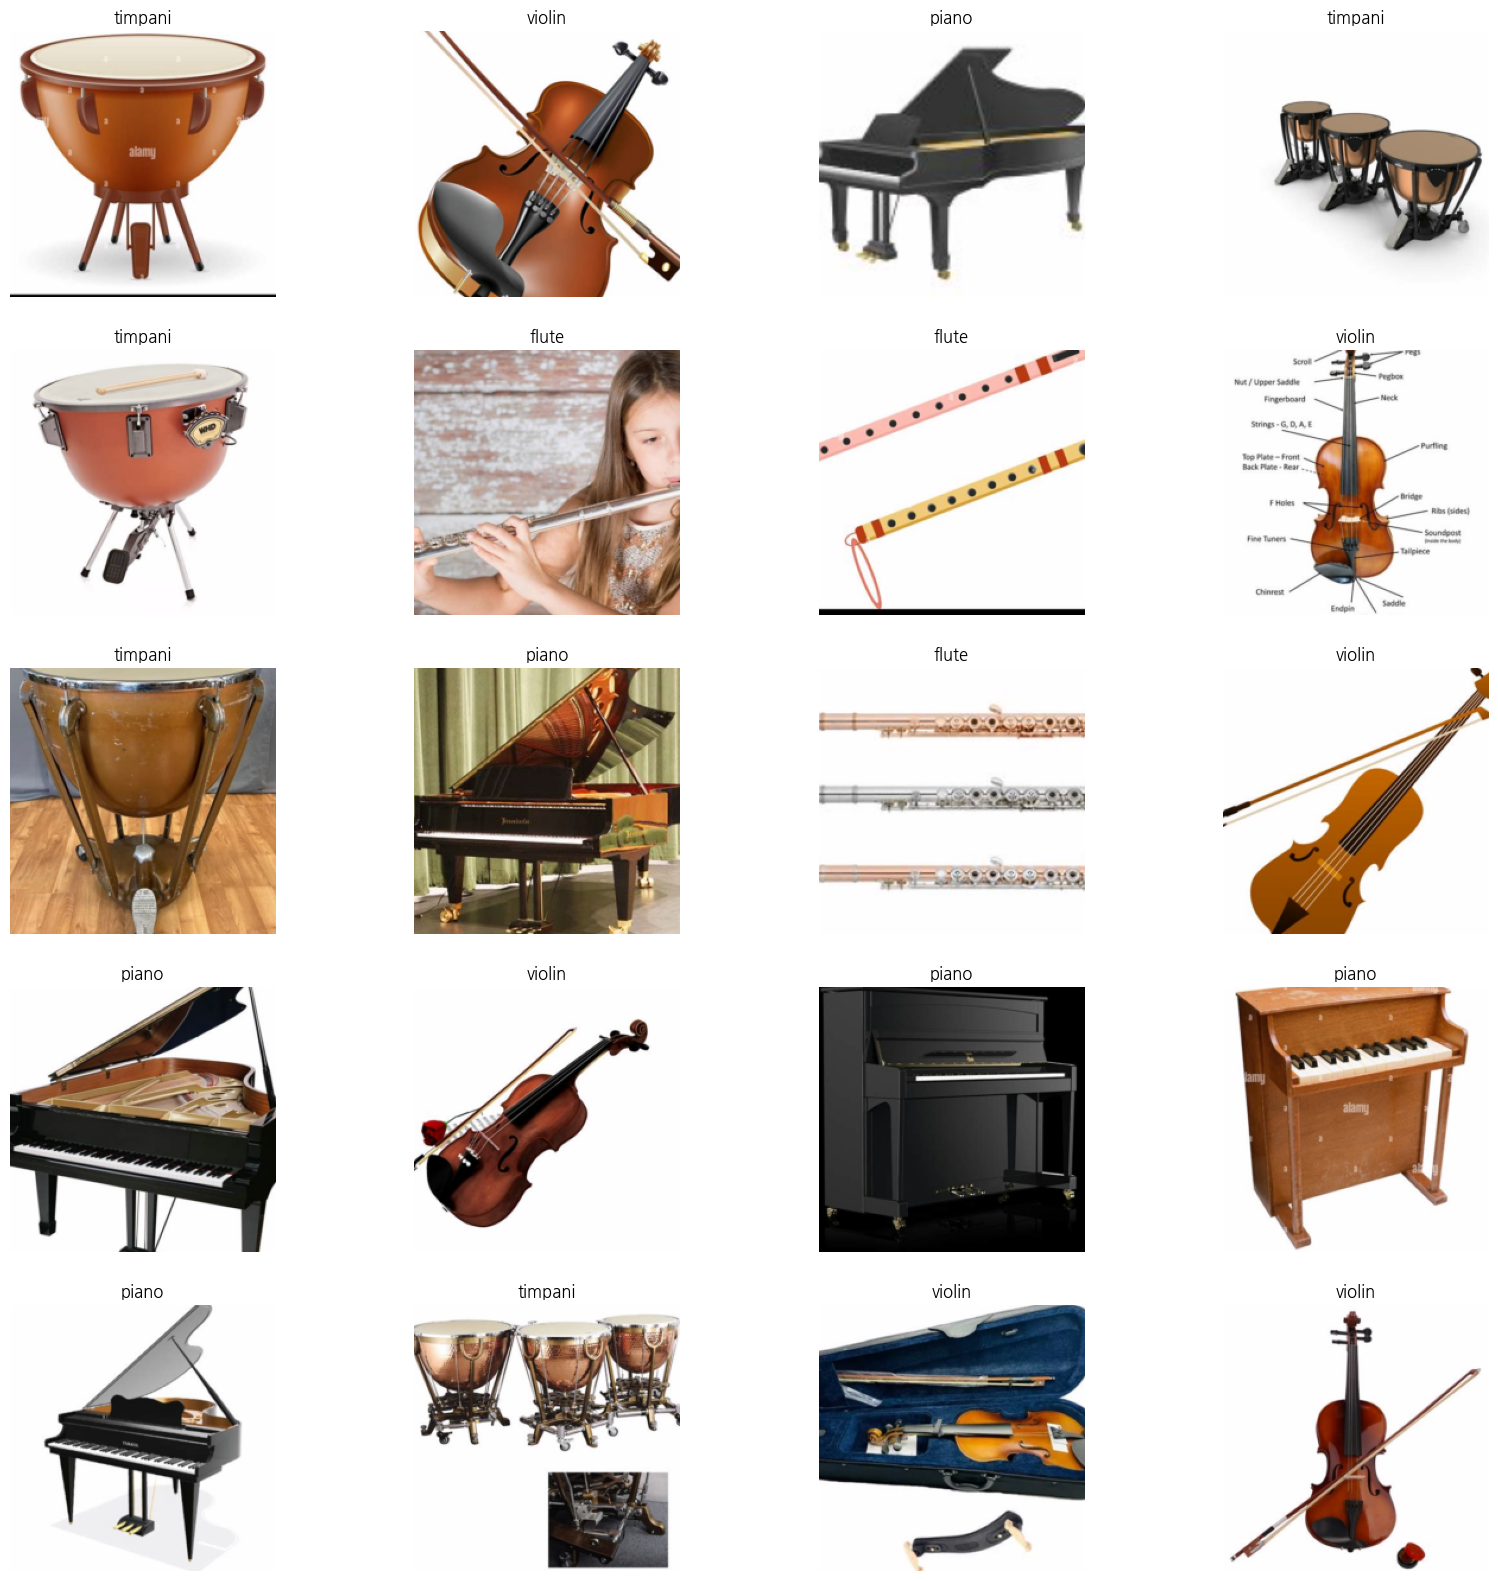

In [14]:
show_batch(train_loader, random_seed=0)
save_fig_with_date("train_batch") # Don't forget to always save the data

### Trainer Class

In [ ]:
import numpy as np
from tqdm.auto import tqdm


class Trainer:
  def __init__(self, model, train_loader, valid_loader, model_name='resnet'):
    self.model = model
    self.train_loader = train_loader
    self.valid_loader = valid_loader
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.model.to(self.device)
    self.criterion = nn.NLLLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
    self.best_loss = np.inf
    self.best_acc = 0.0
    self.train_losses = []
    self.valid_losses = []
    self.train_accs = []
    self.valid_accs = []
    self.model_name = model_name

  def validation(self):
    self.model.eval() # change the model from train mode to evaluation mode
    # Some models work in different ways based on whtehter it is on training step
    # or on inference step

    # In validation step, you don't have to calculate the gradient
    # with torch.no_grad():

    current_loss = 0
    num_total_correct_pred = 0
    with torch.inference_mode(): # every torch computation under this indent
    # will be run without calculating the gradient or computation history
      for batch in self.valid_loader:
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)
        outputs = self.model(images)
        probs = torch.softmax(outputs, dim=-1)
        log_probs = torch.log(probs)

        loss = self.criterion(log_probs, labels)
        predicted_classes = torch.argmax(outputs, dim=-1)
        num_acc_pred = (predicted_classes == labels.to(self.device)).sum()
        #num_acc_pred is on self.device
        num_total_correct_pred += num_acc_pred.item()
        # in validation stage, we don't care about single batch's loss
        # we want to see the result for total images of validation set

        current_loss += loss.item() * len(labels)
        # instead of adding the mean loss, we add sum of loss
        # because the batch size can be different
    mean_loss = current_loss / len(self.valid_loader.dataset)
    mean_acc = num_total_correct_pred / len(self.valid_loader.dataset) # number of total datasample in the validation loader
    return mean_loss, mean_acc
    # return {'loss': mean_loss, 'acc': mean_acc}



  def train_by_number_of_epochs(self, num_epochs):
    for epoch in tqdm(range(num_epochs)):
      self.model.train()
      for batch in tqdm(self.train_loader, leave=False):
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)
        self.optimizer.zero_grad()
        outputs = self.model(images) # this is logits
        probs = torch.softmax(outputs, dim=-1)
        log_probs = torch.log(probs)
        loss = self.criterion(log_probs, labels) # you have to feed log_probs

        acc = (torch.argmax(outputs, dim=-1) == labels.to(self.device)).sum() / len(labels)
        # for torch.nn.NLLLoss
        loss.backward()
        self.optimizer.step()

        self.train_losses.append(loss.item())
        self.train_accs.append(acc.item())
        # don't try self.train_losses.append(loss)
      # training step has ended
      # we want to test our model on the validation set
      valid_loss, valid_acc = self.validation()

      # is this model the best?
      # let's decide it based on valid_acc
      if valid_acc > self.best_acc:
        self.best_acc = valid_acc

        # If it is the best model, save the model's weight'
        models_parameters = self.model.state_dict()
        print(f"Saving best model at epoch {len(self.valid_accs)}, acc: {valid_acc}")
        torch.save(models_parameters, f'{self.model_name}_best.pt')

      self.valid_losses.append(valid_loss)
      self.valid_accs.append(valid_acc)

    # Plot Accuracy curve
    plt.plot(self.train_accs)
    plt.plot(range(len(self.train_loader)-1, len(self.train_accs), len(self.train_loader)) ,self.valid_accs)
    plt.title("Accuracy")


class Interpreter:
  def __init__(self, model, test_loader):
    self.model = model
    self.loader = test_loader
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.criterion = nn.NLLLoss(reduction='none')

    self.test_losses, self.test_preds = self.infer_loader()

  def infer_loader(self):
    self.model.to(self.device)
    self.model.eval()
    losses = torch.zeros(len(self.loader.dataset))
    predicted_classes = torch.zeros(len(self.loader.dataset))
    current_idx = 0
    with torch.inference_mode():
      for batch in self.loader:
        imgs, labels = batch
        imgs, labels = imgs.to(self.device), labels.to(self.device)
        outputs = self.model(imgs)
        log_probs = torch.log(torch.softmax(outputs, dim=-1))
        loss = self.criterion(log_probs, labels)
        losses[current_idx:current_idx+len(labels)] = loss.cpu()
        predicted_classes[current_idx:current_idx+len(labels)] = torch.argmax(outputs, dim=-1).cpu()
        current_idx += len(labels)
    predicted_classes = predicted_classes.long().tolist()
    return losses, predicted_classes


  def plot_top_losses(self, topk=10):
    top_losses, top_idx = torch.topk(self.test_losses, k=topk)
    fig, axes = plt.subplots(topk, 1, figsize=(5, 5*topk))
    class_names = self.loader.dataset.classes
    for i in range(topk):
      img, label = self.loader.dataset[top_idx[i]]
      axes[i].imshow(tensor2pil(img))
      axes[i].set_title(f"True: {class_names[label]} /  Pred: {class_names[self.test_preds[top_idx[i]]]} / Loss: {top_losses[i]:.4f}, ")
      axes[i].axis('off')

  def plot_confusion_matrix(self):
    class_names = self.loader.dataset.classes
    confusion_matrix = torch.zeros(len(class_names), len(class_names))
    for i in range(len(self.loader.dataset)):
      confusion_matrix[self.loader.dataset[i][1], self.test_preds[i]] += 1
    confusion_matrix = confusion_matrix.numpy()
    plt.figure(figsize = (10,7))
    plt.imshow(confusion_matrix)
    plt.xticks(range(len(class_names)), class_names, rotation=90)
    plt.yticks(range(len(class_names)), class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for (x, y), value in np.ndenumerate(confusion_matrix):
      plt.text(y, x, f"{int(value)}", va="center", ha="center")


### Train a model with random initialization
- The model's weight is initialized with random numbers


In [ ]:
model = torchvision.models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(trainset.classes))
trainer = Trainer(model, train_loader, test_loader, 'without_pretraining')
trainer.train_by_number_of_epochs(num_epochs=15)
save_fig_with_date("model_without_pretraining")

interpreter = Interpreter(model, test_loader)
interpreter.plot_top_losses(topk=10)
save_fig_with_date("model_without_pretraining_top_losses")
interpreter.plot_confusion_matrix()
save_fig_with_date("model_without_pretraining_confusion_mat")


In [ ]:
# you can also plot loss curve

plt.plot(trainer.train_losses)
plt.plot(range(len(trainer.train_loader)-1, len(trainer.train_accs), len(trainer.train_loader)) , trainer.valid_losses)
plt.title("Loss")
plt.ylim([0,3])

### Train a model with pre-trained weight


In [ ]:
# Use the same ResNet18 architecture but using pre-trained weights
# as initial weights
# The weight was trained with ImageNet 1K
model = torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(trainset.classes))
trainer = Trainer(model, train_loader, test_loader, 'with_pretraining')
trainer.train_by_number_of_epochs(num_epochs=15)
save_fig_with_date("model_pretrained")

# the model was trained with 15 epochs
# But the best validation accuracy was achieved in epoch 11 (12th epoch)

interpreter = Interpreter(model, test_loader)
interpreter.plot_top_losses(topk=10)
save_fig_with_date("model_pretrained_top_losses")
interpreter.plot_confusion_matrix()
save_fig_with_date("model_pretrained_confusion_mat")


#### Load Model
- You can load the saved data by `torch.load()`
- You can load the model's weight by `model.load_state_dict(state_dict)`
- The code below will run `plot_top_losses` and `plot_confusion_matrix` with the model at the epoch with the best accuracy

In [ ]:
saved_weight = torch.load('with_pretraining_best.pt')
model.load_state_dict(saved_weight) # load trained weights parameters to the model

interpreter = Interpreter(model, test_loader)
interpreter.plot_top_losses(topk=10)
save_fig_with_date("model_pretrained_best_epoch_top_losses")
interpreter.plot_confusion_matrix()
save_fig_with_date("model_pretrained_best_epoch_confusion_mat")


## Problem 3: Clean your Dataset
- The goal of data cleaning is to make sure that your dataset consists of images with specific characteristics you want.

- Cell below is the modified version of `jmd_imagescraper.imagecleaner import display_image_cleaner`
  - Once you run it, you can call `display_image_clenaer`
  - *YOU HAVE TO RELOAD* the UI when you make different `display_image_cleaner`
- If you click `delete` button, the image file will be moved to `DEL_DIR`, which is in default `images/deleted`
- After the cleaning YOU HAVE TO SAVE YOUR RESULT by running the cell below.

- **CAUTION** If this UI is too slow, you can also clean your dataset in your local computer by downloading `img_data.zip` file, and upload cleaned images to the `images/` directory. However, you have to make sure that the directory structure is same as the original one.
- 이 UI가 느릴 수 있기 때문에 필요하면 `img_data.zip` 파일을 다운로드 받아 로컬에서 이미지 파일들을 열어 지우고 싶은 이미지 파일들을 지운 후 다시 같은 폴더 구조로 업로드하여 진행하여도 됩니다.

- TODO:
  - Explain your criteria in cleaning certain examples


#### Cleaner code (run it without opening it)

In [ ]:
#hide
from pathlib import Path
from PIL import Image as PImage
from PIL import ImageDraw as PImageDraw
import ipywidgets as widgets
from IPython.display import display
from io import BytesIO

##########################################################################################
# globals & event handlers
##########################################################################################
ICLN_BATCH_SZ = 8

# this may look nauseating and but creating new widgets is literally about 10x slower than
# updating existing ones so the ui gets created once and updated forever more
icln_base_path = None
icln_folder = None
icln_batches = None
icln_pager = None
icln_grid = None
icln_empty_folder = None

def delete_on_click(btn):
  fn, img, batch, idx = btn.tag
  img.value = icln_deleted_img() # display red 'deleted' cross
  icln_batches[batch][idx] = ""  # so we know it's deleted as we page back & forth
  btn.disabled = True
  # try:    Path(fn).unlink()      # dbl-clicks result in us trying to delete twice
  try: shutil.move(str(fn), DEL_DIR)
  except Exception as e: print(e)

def paging_on_click(btn):
  folder, batch = btn.tag
  icln_render_batch(folder, batch)

def reload_on_click(btn):
  icln_render_batch(icln_folder, 0, force_reload=True)

def folder_on_change(change):
  if(change["type"] == "change" and change["name"] == "value"):
    icln_render_batch(change["new"], 0)

##########################################################################################
# UI creation
##########################################################################################
def icln_deleted_img():
  # creates the red "deleted" placeholder cross and caches it
  DELETED_IMG = "deleted_img"

  if(DELETED_IMG not in icln_deleted_img.__dict__):
    img = PImage.new("RGB",(150,150), color="white")

    draw = PImageDraw.Draw(img)
    draw.line((5, 5, 140, 140), fill="red", width=10)
    draw.line((5, 140, 140, 5), fill="red", width=10)

    bio = BytesIO()
    img.save(bio, 'JPEG')
    icln_deleted_img.__dict__[DELETED_IMG] = bio.getvalue()

  return icln_deleted_img.__dict__[DELETED_IMG]

def icln_create_widgets(batch_size):
  # create the UI widgets
  global icln_pager
  global icln_grid
  global icln_empty_folder

  # image/delete button pairs
  display_items = []
  for i in range(batch_size):
    img = widgets.Image()
    img.layout.width="150px"
    btn = widgets.Button(description="Delete")
    btn.on_click(delete_on_click)
    box = widgets.VBox(children=[img,btn])
    box.layout.margin = "5px"
    display_items.append(box)

  # paging
  btnFirst = widgets.Button(description="|<<")
  btnPrev = widgets.Button(description="<<")
  lblPage = widgets.Label(value="Page NNN of KKK")
  lblPage.layout = widgets.Layout(display="flex", justify_content="center", width="100px")
  btnNext = widgets.Button(description=">>")
  btnLast = widgets.Button(description=">>|")

  pgbtns = [btnFirst, btnPrev, btnNext, btnLast]
  for btn in pgbtns: btn.on_click(paging_on_click)
  for btn in pgbtns: btn.layout.width = "60px"

  # folder drop down
  folders = [f.stem for f in icln_base_path.glob("*") if (f.is_dir() and f.stem[0] != ".")]
  folders.sort()
  rootfiles = [f for f in icln_base_path.glob("*.jpg") if f.is_file()]
  if(len(rootfiles) > 0): folders = ["/"] + folders
  ddlFolder = widgets.Dropdown(options=folders, description="Folder: ")
  ddlFolder.observe(folder_on_change)

  # reload button
  btnReload = widgets.Button(description="↻")
  btnReload.layout = widgets.Layout(width="40px", margin="0px 0px 0px 10px")
  btnReload.on_click(reload_on_click)

  # plug it all in and display
  icln_pager = widgets.HBox(children=[btnFirst, btnPrev, lblPage, btnNext, btnLast,
                                      ddlFolder, btnReload])
  icln_grid = widgets.GridBox(display_items,
                              layout=widgets.Layout(grid_template_columns="repeat(4, 25%)",
                                                    margin="15px"))
  icln_empty_folder = widgets.HTML(value="<h2>No images left to display in this folder.</h2>")
  icln_empty_folder.layout.visibility = "hidden"

  display(icln_pager)
  display(icln_empty_folder)
  display(icln_grid)

##########################################################################################
# UI rendering
##########################################################################################
def icln_render_batch(folder, batch, force_reload=False):
  global icln_folder
  global icln_batches
  global icln_pager
  global icln_grid

  if(folder == "/"): folder = ""
  path = icln_base_path/folder

  if((icln_folder != folder) or (force_reload)):
    # get the files, split into batches
    files = list(path.glob("*.jpg"))
    icln_batches = [files[i:i + ICLN_BATCH_SZ] for i in range(0, len(files), ICLN_BATCH_SZ)]
    icln_folder = folder

    if(len(files) == 0):
      # fail gracefully if they've deleted every image in this folder
      icln_empty_folder.layout.visibility = "visible"
      # icln_grid.layout.visibility = "hidden" <-- doesn't work :-@
      for child in icln_grid.children: child.layout.visibility = "hidden"
      btnFirst, btnPrev, lblPage, btnNext, btnLast,_,_ = icln_pager.children
      lblPage.value = "Page 0 of 0"
      for btn in [btnFirst, btnPrev, btnNext, btnLast]: btn.disabled = True
      return
    else:
      icln_empty_folder.layout.visibility = "hidden"
      icln_grid.layout.visibility = "visible"

  # display the images
  for i, fp in enumerate(icln_batches[batch]):
    icln_grid.children[i].layout.visibility = "visible"
    img = icln_grid.children[i].children[0]
    btn = icln_grid.children[i].children[1]

    if(fp == ""):
      img.value = icln_deleted_img()
      btn.disabled = True
    else:
      img.value = open(fp, "rb").read()
      btn.tag = (fp, img, batch, i)
      btn.disabled = False

  if(len(icln_batches[batch]) < ICLN_BATCH_SZ):
    # partial batch on the last page, hide the rest of the grid
    for i in range(len(icln_batches[batch]), ICLN_BATCH_SZ):
      icln_grid.children[i].layout.visibility = "hidden"

  # update the paging controls
  btnFirst, btnPrev, lblPage, btnNext, btnLast,_,_ = icln_pager.children
  btnFirst.tag = (folder, 0)
  btnPrev.tag = (folder, max(0, batch-1))
  btnNext.tag = (folder, min(len(icln_batches)-1, batch+1))
  btnLast.tag = (folder, len(icln_batches)-1)
  lblPage.value = "Page {} of {}".format(batch+1, len(icln_batches))
  for btn in [btnFirst, btnPrev, btnNext, btnLast]: btn.disabled = btn.tag[1] == batch

def display_image_cleaner(path):
    '''Display the image cleaner widget for the given folder'''
    global icln_base_path; icln_base_path = Path(path)

    icln_create_widgets(ICLN_BATCH_SZ)
    _,_,_,_,_,ddlFolder,_ = icln_pager.children
    icln_render_batch(ddlFolder.value, 0)

#### Run `display_image_cleaner`

In [ ]:
DEL_DIR.mkdir(exist_ok=True, parents=True)
display_image_cleaner('images/train')

In [ ]:
# DO NOT FORGET TO CLICK RELOAD BUTTON on the top right of the UI
display_image_cleaner('images/test')

- Don't Forget to save your data

In [ ]:
os.system(f"zip -rq image_data_cleaned.zip {IMG_DIR}") # Make zip file that contains images directory
save_file("image_data_cleaned.zip")

# Problem 4. Train a new model with cleaned dataset
- TODO:
  - Explain whether the model's prediction has changed to what you have expected

In [ ]:

trainset = ImageSet(IMG_DIR/'train')
testset = ImageSet(IMG_DIR/'test')
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

model = torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(trainset.classes))
trainer = Trainer(model, train_loader, test_loader, 'after_cleaning')
trainer.train_by_number_of_epochs(num_epochs=15)
save_fig_with_date("model_after_cleaning")
model.load_state_dict(torch.load('after_cleaning_best.pt'))
interpreter = Interpreter(model, test_loader)
interpreter.plot_top_losses(topk=10)
save_fig_with_date("model_after_cleaning_top_losses")
interpreter.plot_confusion_matrix()
save_fig_with_date("model_after_cleaning_confusion_mat")

# Problem 5 Test with Custom Image and Explain
- Test your model with a custom input image
  - Upload `jpg` files to `custom_images/`
  - You can use drag and drop on Colab
  - Test **at least 10 images**

- TODO:
  - Find failure cases and try to __explain__ why the model fails to classify it correctly
  - In your opinion, what is the important pattern/characteristics that decides model's classification process? Why?
  - It is important to test images that can provide you some clue, or give evidence for your hypothesis

In [ ]:
# YOU HAVE TO UPLOAD YOUR JPG IMAGE TO custom_images/ TO RUN THIS CELL
custom_image_dir = Path("custom_images/") # Path to directory containing custom images
custom_image_dir.mkdir(exist_ok=True, parents=True) # Make Directory


In [ ]:
# Automatically find jpg and png files in custom_image_dir
custom_image_fns = list(custom_image_dir.glob("*.jpg")) + list(custom_image_dir.glob("*.png"))

model.cpu()
model.eval()
plt.figure(figsize=(5, 5*len(custom_image_fns)))
for i, fn in enumerate(custom_image_fns):
  plt.subplot(len(custom_image_fns), 1, i+1)
  img = Image.open(fn)
  plt.imshow(img)
  img_tensor = testset.transform(img)
  pred = model(img_tensor.unsqueeze(0))
  pred_class = trainset.classes[pred.argmax()]
  plt.title(f"Prediction: {pred_class} / Confidence: {pred.softmax(dim=-1).max():.3f}")
  plt.axis("off")
save_fig_with_date("custom_images_predictions")
